In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from graph_tool.all import *
from math import * 
import pandas as pd
import sys
import gc
import numpy as np

In [26]:
def getDirPaths(vtx, myg, thisV=[], allV=[]):
    if vtx in thisV:  #if reached loop, return
        thisV += [vtx]
        return allV
    elif vtx.out_degree()==0:  #if reached another leaf, return
        thisV += [vtx]
        allV += [thisV]
        return allV
    else:
        thisV += [vtx]
        outs = vtx.out_neighbours()
        for v2 in outs:
            nextV =list(thisV)
            allV = getDirPaths(v2,myg,nextV,allV)
    return allV


In [27]:
def getHomoplasies(gr,paths,alls):
    reverts = dict()
    counts = dict()
    for path in paths:
        homoplasy=0
        concord=0
        invar=0
        for i in alls.index:
            ch = alls["chr"][i]
            po = alls["pos"][i]
            ty = alls["type"][i]

            startGeno=None
            currentGeno=0
            currentVx="0"
            muts=0
            status="null"
            for vx in path:
                vxns=gr.properties[("v","name")]
                vxn = vxns[vx]
                gt= alls[vxn][i].rstrip()
                #print str(gt),

                if gt == '.':
                    continue

                if startGeno is None:
                    startGeno = gt
                elif gt != currentGeno:
                    muts += 1
                    if gt != startGeno:
                        status="mut"+str(muts)
                    else:
                        status="revertant"
#                        if vxn not in reverts: reverts[vxn]=set()
#                        reverts[vxn].add((ch,po,currentVx,vxn,ty))
                        if vxn not in reverts: reverts[vxn]=dict()
                        reverts[vxn][(ch,po,ty)]=(currentVx,vxn)
                        homoplasy+=1
                if vxn not in counts: counts[vxn]=set()
                counts[vxn].add((ch,po,ty))
                currentGeno = gt
                currentVx=vxn
#            if status=="revertant":
                #for vx in path:
                #    gt= alleles[name[vx]][i].rstrip()
                #    print gt,
                #print ""
#                homoplasy +=1
#            elif status=="null":
#                invar+=1
#            else:
#                concord+=1

        for v in path:
            print " ",name[v],
        print "\t"+",".join(map(str,[homoplasy,concord,invar]))
    return reverts, counts



In [28]:
def makeHPSmatrix(alleles, hps):
    x,y = alleles.shape
    hpsout=np.zeros((x,y-5),dtype=np.int)
    samples = alleles.columns[5:]
#    si=0
    HPSi=0
    for vxn in samples:
        ai=0
        for a in alleles[vxn]:
            ch = alleles["chr"][ai]
            po = alleles["pos"][ai]
            ty = alleles["type"][ai]

            isHPS=0
            if vxn in hps:
                L = list(hps[vxn])
                L.sort()
#                if (ch,po,vfr,vto,ty) in list(hps[vxn]):
                if (ch,po,ty) in hps[vxn]:
    #                print ch,po,ty,vxn
                    (vfr,vto) = hps[vxn][(ch,po,ty)]
                    vfri=samples.tolist().index(vfr)
                    vtoi=samples.tolist().index(vto)
#                    print vfri, vtoi
                    if hpsout[((ai,vfri))] > 0:
                        hpsout[((ai,vtoi))]=hpsout[((ai,vfri))]
                    else:
                        HPSi+=1
                        hpsout[((ai,vfri))]=HPSi
                        hpsout[((ai,vtoi))]=HPSi$h
                    
            ai+=1
#        si+=1
    return hpsout

In [29]:
alltab = "./clade29.alleles.tab.txt"
alleles = pd.read_table(alltab)

#alleles = alleles[2]


  Th086.07   Th106.09   Th106.11 	377,0,0
  Th086.07   Th106.09   Th132.11   Th230.12 	93,0,0
  Th086.07   Th106.09   Th162.12 	30,0,0
  Th086.07   Th106.09   Th196.12 	32,0,0
  Th086.07   Th106.09   Th074.13 	35,0,0
  Th086.07   Th117.11 	0,0,0
  Th086.07   Th134.11 	0,0,0
0.0
0.0
0.0
0.285388127854
0.023166023166
0.023023791251
0.023988005997
0.026256564141
0.0486111111111


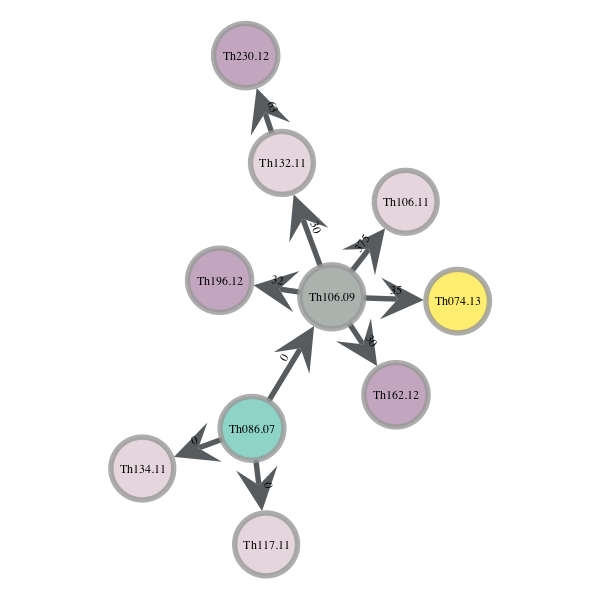

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x11d4bf5d0, at 0x11aea6850>

In [30]:

dotfile="./clade29.seqtrack.SIscaled.xml"
gr = load_graph(dotfile,fmt="graphml")
year = gr.vertex_properties["year"]
name = gr.vertex_properties["name"]
oyr = min([year[v] for v in gr.vertices()])
o=[v for v in gr.vertices() if year[v]==oyr][0]
paths = getDirPaths(o,gr)

hps, cts = getHomoplasies(gr,paths,alleles)
hp = gr.new_edge_property("int")
ct = gr.new_edge_property("int")
hppc = gr.new_edge_property("float")

for e in gr.edges(): 
    v=e.target()
    hpct=0
    if name[v] in hps:
        hpct=len(list(hps[name[v]]))
    varct=len(list(cts[name[v]]))
    hp[e] = hpct
    ct[e] = varct
    print hpct/float(varct)
    hppc[e] = hpct/float(varct)

graph_draw(gr,vertex_text=name,vertex_fill_color=year,edge_text=hp)

In [10]:
gr.properties[('v','homoplasy_percent')] = hppc
gr.properties[('v','homoplasy_count')] = hp

gr.save(dotfile.replace(".xml",".HPLSY.xml"))

In [11]:
samples = alleles.columns[5:]
hpsout=makeHPSmatrix(alleles,hps)
hpsout2 = pd.concat([alleles[["chr","pos","type","subtype","alleles"]],pd.DataFrame(hpsout, columns=samples)],axis=1)
hpsout2.to_csv(dotfile.replace(".xml",".HPLSY.txt"),sep="\t",index=False)

In [12]:
hpsout2


,chr,pos,type,subtype,alleles,Th074.13,Th086.07,Th106.09,Th106.11,Th117.11,Th132.11,Th134.11,Th162.12,Th196.12,Th230.12
0,Pf3D7_01_v3,98868,SNP,ts,A/G,0,0,0,0,0,0,0,0,0,0
1,Pf3D7_01_v3,102006,SNP,tv,A/T,0,0,0,0,0,0,0,0,0,0
2,Pf3D7_01_v3,123985,SNP,tv,G/T,0,0,0,0,0,0,0,0,0,0
3,Pf3D7_01_v3,123987,SNP,tv,A/T,0,0,0,0,0,0,0,0,0,0
4,Pf3D7_01_v3,123991,SNP,tv,A/T,0,0,0,0,0,0,0,0,0,0
5,Pf3D7_01_v3,123993,SNP,tv,A/T,0,0,0,0,0,0,0,0,0,0
6,Pf3D7_01_v3,123994,INDEL,ins,A/ATTTTATTTTATT,0,0,0,0,0,0,0,0,0,0
7,Pf3D7_01_v3,124002,SNP,tv,T/A,0,0,0,0,0,0,0,0,0,0
8,Pf3D7_01_v3,124050,SNP,tv,T/A,0,0,0,0,0,0,0,0,0,0
9,Pf3D7_01_v3,124474,SNP,tv,A/T,0,0,0,0,0,0,0,0,0,0
